# Prepare Dataset


In [108]:
from __future__ import print_function

import logging
import os
import re

import gensim
import nltk
import pandas as pd
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from numpy import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


In [109]:
data = pd.read_csv(
    "./input/deceptive-opinion-spam-corpus/deceptive-opinion.csv"
)

In [110]:
df = data.drop(["hotel", "polarity", "source"], axis=1)

In [111]:
df1 = df.sample(frac=1)

In [112]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df1["deceptive"] = label_encoder.fit_transform(df1["deceptive"])

df1["deceptive"].unique()

array([0, 1])

In [113]:
df1.describe()

,deceptive
count,1600.000000
mean,0.500000
std,0.500156
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


# Data preprocessing


In [114]:
from nltk.corpus import stopwords
import re

REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile("[^0-9a-z #+_]")
STOPWORDS = set(stopwords.words("english"))


def clean_text(text):
    """
    text: a string

    return: modified initial string
    """
    # text = BeautifulSoup(text, "lxml").text  # HTML decoding
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


df1["text"] = df1["text"].apply(clean_text)

In [115]:
X = df1.text
y = df1.deceptive

In [116]:
X = X.map(lambda a: clean_text(a))

In [117]:
def text_to_wordlist(text):
    # Remove Special Characters
    text = re.sub(r"[^a-z\d ]", " ", text)
    text = re.sub(r"\d+", "_num_", text)
    return text

In [118]:
X = X.map(lambda a: text_to_wordlist(a))

In [119]:
# X_train, y_train for training (70%)
# X_val, y_val for development (15%)
# X_test, y_test for testing (15%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% dev, 15% test

# train, test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [120]:
tokenizer = Tokenizer(
    num_words=None,
    lower=True,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    split=" ",
    char_level=False,
)

In [121]:
tokenizer.fit_on_texts(X)

In [122]:
x_train = tokenizer.texts_to_sequences(X_train)
x_val = tokenizer.texts_to_sequences(X_val)
x_test = tokenizer.texts_to_sequences(X_test)

In [123]:
word_index = tokenizer.word_index

In [124]:
X = tokenizer.texts_to_sequences(X)

In [125]:
vocab_size = len(word_index)
print("Vocab size: {}".format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print("Max comment size: {}".format(max_len))

Vocab size: 9340
Longest comment size: 795
Average comment size: 150.633125
Stdev of comment size: 88.63532607112344
Max comment size: 416


In [126]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [127]:
processed_post_x_train = pad_sequences(
    x_train, maxlen=max_len, padding="post", truncating="post"
)
processed_post_x_val = pad_sequences(
    x_val, maxlen=max_len, padding="post", truncating="post"
)
processed_post_x_test = pad_sequences(
    x_test, maxlen=max_len, padding="post", truncating="post"
)

In [128]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_val = pad_sequences(x_val, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [129]:
print("x_train shape:", processed_x_train.shape)
print("x_test shape:", processed_x_test.shape)

x_train shape: (1120, 416)
x_test shape: (240, 416)


In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    BatchNormalization, Dropout, Embedding
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [131]:
embeddings_index = {}
f = open(
    os.path.join(
        "./input/glove-global-vectors-for-word-representation", "glove.6B.100d.txt"
    )
)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [132]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [133]:
# Initate model
model = Sequential()

model.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)

model.add(LSTM(60, return_sequences=True, name="lstm_layer1"))
model.add(LSTM(30, return_sequences=True, name="lstm_layer2"))
model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

model.add(
    Dense(64, activation="relu", kernel_regularizer=l2(0.17), bias_regularizer=l2(0.01))
)
model.add(Dropout(0.3))
model.add(
    Dense(
        32, activation="sigmoid", kernel_regularizer=l2(0.19), bias_regularizer=l2(0.01)
    )
)
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# LSTM-Conv1D

## Train

In [135]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [136]:
filepath = "./results/Conv1D-glove100D-{epoch:02d}-{val_accuracy:.2f}.hdf5"

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"),
]

In [137]:
want_load = False
model_checkpoint = "./results/weights-improvement-12-0.88.hdf5"

if want_load:
    model = get_model()
    model.load_weights(model_checkpoint)

In [138]:
history = model.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_val),
    epochs=15,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15


35/35 [==============================] - ETA: 0s - loss: 17.9946 - accuracy: 0.5848
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./results\Conv1D-glove100D-01-0.50.hdf5
35/35 [==============================] - 19s 478ms/step - loss: 17.9946 - accuracy: 0.5848 - val_loss: 13.4365 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
35/35 [==============================] - ETA: 0s - loss: 10.2721 - accuracy: 0.7277
Epoch 2: val_accuracy did not improve from 0.50000
35/35 [==============================] - 11s 307ms/step - loss: 10.2721 - accuracy: 0.7277 - val_loss: 7.7375 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
35/35 [==============================] - ETA: 0s - loss: 5.7811 - accuracy: 0.8009
Epoch 3: val_accuracy did not improve from 0.50000
35/35 [==============================] - 11s 304ms/step - loss: 5.7811 - accuracy: 0.8009 - val_loss: 4.5295 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 4/15
35/35 [==============================] - ETA: 0s - loss: 3.2736 - a

## Evaluation

In [139]:
def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    
    plt.tight_layout()
    plt.show()

8/8 [==============================] - 1s 89ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       117
           1       0.89      0.83      0.86       123

    accuracy                           0.86       240
   macro avg       0.86      0.86      0.86       240
weighted avg       0.86      0.86      0.86       240



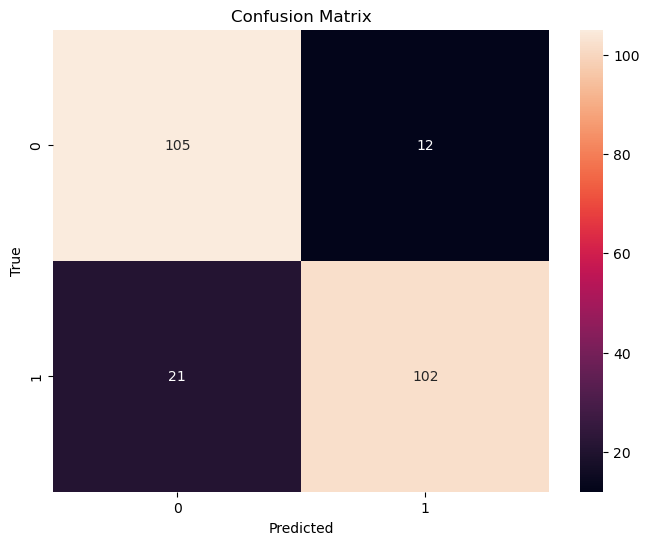

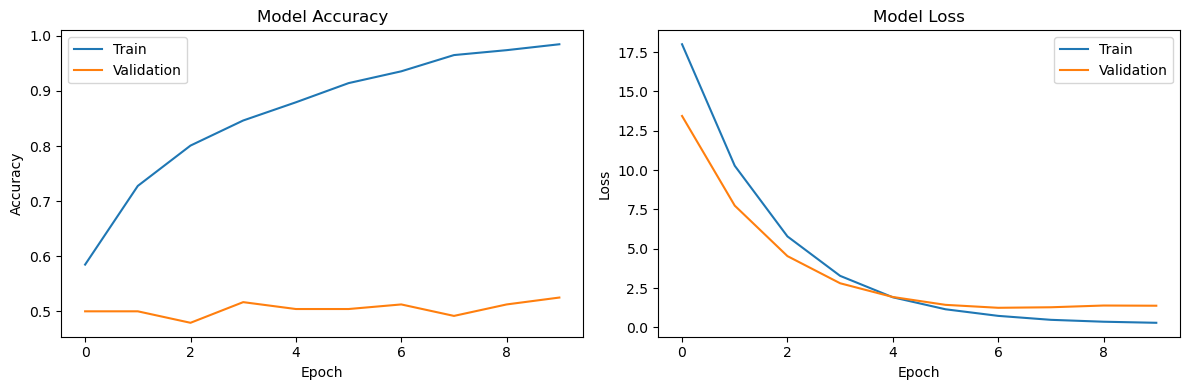

In [140]:
evaluate_model(model, processed_x_test, y_test)

# CNN GLoVe

## Train

In [141]:
model_glove = Sequential()
model_glove.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)
model_glove.add(Dropout(0.2))
model_glove.add(
    Conv1D(
        64, 5, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    )
)
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(BatchNormalization())
model_glove.add(LSTM(100, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model_glove.add(
    Dense(
        1, activation="sigmoid", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    )
)

model_glove.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 416, 100)          934100    
                                                                 
 dropout_12 (Dropout)        (None, 416, 100)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 412, 64)           32064     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 103, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 103, 64)          256       
 hNormalization)                                                 
                                                                 
 lstm_6 (LSTM)               (None, 100)              

In [142]:
model_glove.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [143]:
history = model_glove.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
)

Epoch 1/30
35/35 [==============================] - 4s 80ms/step - loss: 2.8333 - accuracy: 0.5661 - val_loss: 2.1674 - val_accuracy: 0.5208
Epoch 2/30
35/35 [==============================] - 2s 64ms/step - loss: 1.7108 - accuracy: 0.6768 - val_loss: 1.4577 - val_accuracy: 0.6125
Epoch 3/30
35/35 [==============================] - 2s 64ms/step - loss: 1.1450 - accuracy: 0.7786 - val_loss: 1.1823 - val_accuracy: 0.6000
Epoch 4/30
35/35 [==============================] - 2s 64ms/step - loss: 0.8639 - accuracy: 0.8375 - val_loss: 0.9429 - val_accuracy: 0.7542
Epoch 5/30
35/35 [==============================] - 2s 64ms/step - loss: 0.6435 - accuracy: 0.9098 - val_loss: 0.8445 - val_accuracy: 0.7792
Epoch 6/30
35/35 [==============================] - 2s 64ms/step - loss: 0.5819 - accuracy: 0.9125 - val_loss: 0.7918 - val_accuracy: 0.8083
Epoch 7/30
35/35 [==============================] - 2s 64ms/step - loss: 0.5340 - accuracy: 0.9312 - val_loss: 0.7561 - val_accuracy: 0.7750
Epoch 8/30
35

## Evaluation


8/8 [==============================] - 1s 21ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       117
           1       0.90      0.76      0.82       123

    accuracy                           0.83       240
   macro avg       0.84      0.84      0.83       240
weighted avg       0.84      0.83      0.83       240



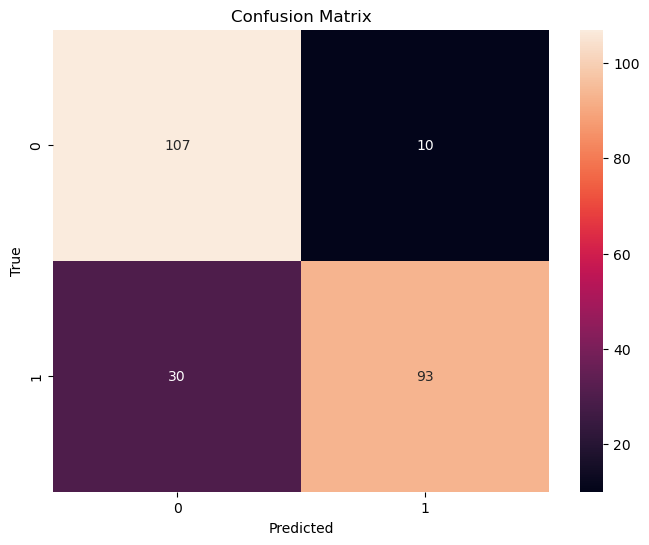

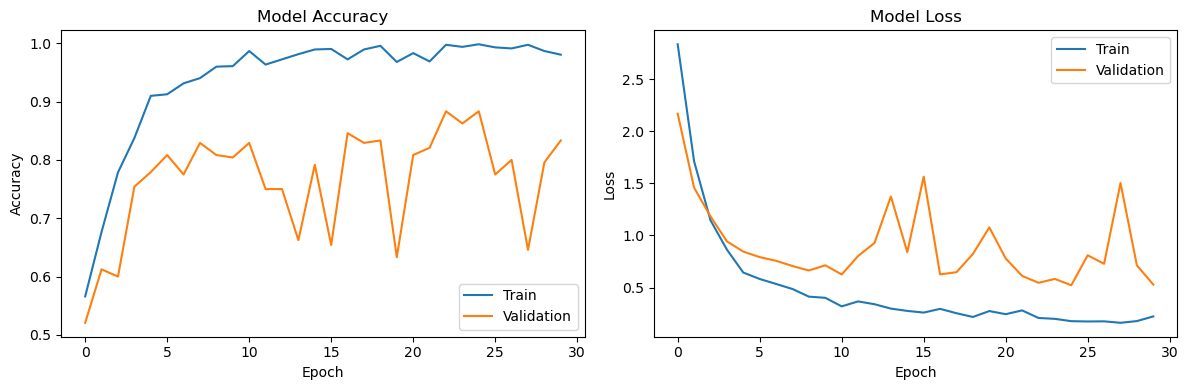

In [155]:
evaluate_model(model_glove, processed_x_test, y_test)

# 2 Layer LSTM


## Train

In [147]:
# Initate model
model_lstm = Sequential()


model_lstm.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)

input_shape = embedding_matrix[0].shape


# ,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model_lstm.add(LSTM(60, return_sequences=True, name="lstm_layer1"))
# kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model_lstm.add(LSTM(30, return_sequences=True, name="lstm_layer2"))
# model_lstm.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
# model_lstm.add(MaxPooling1D(3))
# model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(BatchNormalization())
model_lstm.add(Flatten())
model_lstm.add(
    Dense(64, activation="relu", kernel_regularizer=l2(0.17), bias_regularizer=l2(0.01))
)
model_lstm.add(Dropout(0.3))
model_lstm.add(
    Dense(
        32, activation="sigmoid", kernel_regularizer=l2(0.19), bias_regularizer=l2(0.01)
    )
)
model_lstm.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dense(20, activation="relu", input_shape=input_shape))
# model.add(Dense(20, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation="sigmoid"))
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 416, 100)          934100    
                                                                 
 lstm_layer1 (LSTM)          (None, 416, 60)           38640     
                                                                 
 lstm_layer2 (LSTM)          (None, 416, 30)           10920     
                                                                 
 batch_normalization_6 (Batc  (None, 416, 30)          120       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 12480)             0         
                                                                 
 dense_16 (Dense)            (None, 64)                798784    
                                                      

In [152]:
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [153]:
hist = model_lstm.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1,
)

Epoch 1/15
35/35 [==============================] - 19s 450ms/step - loss: 4.2087 - accuracy: 0.6777 - val_loss: 3.2847 - val_accuracy: 0.7583
Epoch 2/15
35/35 [==============================] - 13s 360ms/step - loss: 2.6114 - accuracy: 0.7411 - val_loss: 2.1041 - val_accuracy: 0.7792
Epoch 3/15
35/35 [==============================] - 12s 354ms/step - loss: 1.6281 - accuracy: 0.8125 - val_loss: 1.4303 - val_accuracy: 0.7958
Epoch 4/15
35/35 [==============================] - 12s 354ms/step - loss: 1.0301 - accuracy: 0.8795 - val_loss: 1.0042 - val_accuracy: 0.7792
Epoch 5/15
35/35 [==============================] - 12s 354ms/step - loss: 0.7142 - accuracy: 0.8973 - val_loss: 0.7574 - val_accuracy: 0.8167
Epoch 6/15
35/35 [==============================] - 12s 356ms/step - loss: 0.5395 - accuracy: 0.9170 - val_loss: 0.7340 - val_accuracy: 0.7667
Epoch 7/15
35/35 [==============================] - 12s 355ms/step - loss: 0.4124 - accuracy: 0.9393 - val_loss: 0.5561 - val_accuracy: 0.8250

## Evaluation

8/8 [==============================] - 2s 125ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       117
           1       0.85      0.89      0.87       123

    accuracy                           0.86       240
   macro avg       0.86      0.86      0.86       240
weighted avg       0.86      0.86      0.86       240



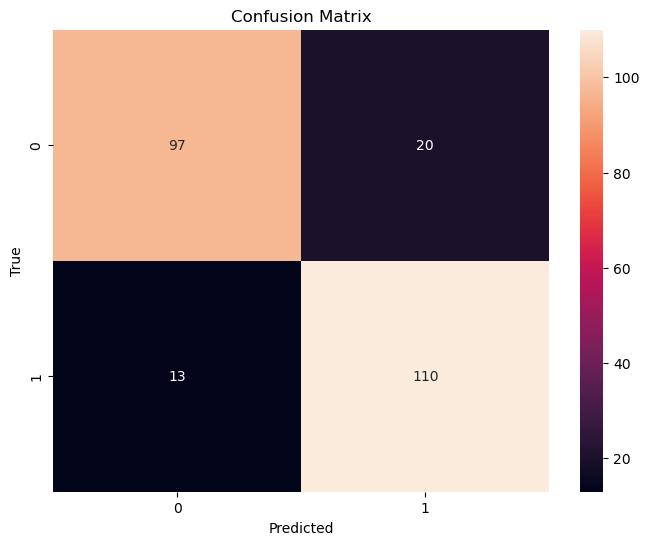

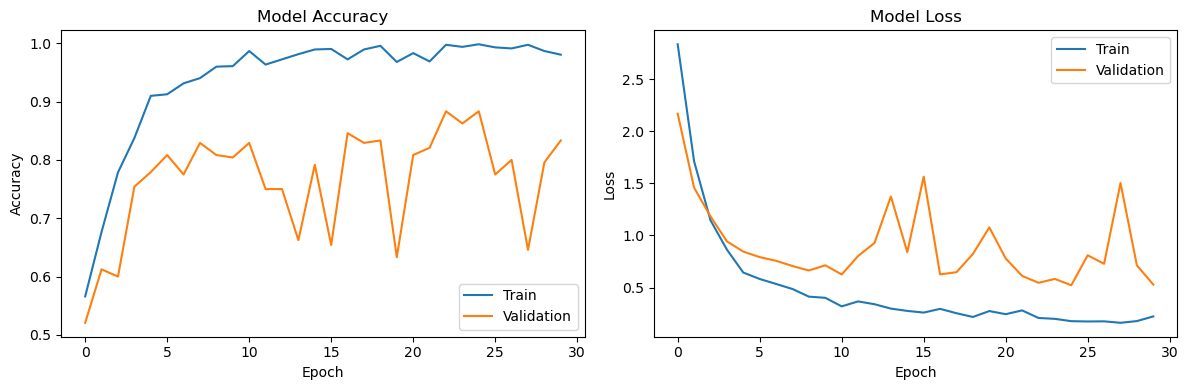

In [156]:
evaluate_model(model_lstm, processed_x_test, y_test)